In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math
%matplotlib inline

employee = pd.read_csv("HR_comma_sep.csv")

employee = employee.rename(columns={'average_montly_hours':'avg_hours'})

# Introduction

I'd like to look at a dataset of employee records from a large company. More specifically, the data contains each employee's workload, evaluation, job satisfaction, and other measures along with a binary for whether or not said employee has left the company. We can thus use it to try to glean some information about what factors influence employee turnover, which can be a big problem for any human resources department or company in today's competitive market for talent.

I'll first try to hone in on some interesting correlations and learnings as relates to employees quitting. Specially, I'll look to probe on the topic of "burnout," and whether employees that seem to have a high workload are quitting at a higher rate and, if so, why exactly that is. However, given that the data is somewhat limited in its level of description of each employee's circumstances and can only hint at more specific hypotheses, I'll use these initial learnings to propose a further experiment to expand on what we uncover.

First, let's just take a quick overview of the data.

In [21]:
#Checking data types and that there are no nulls
print('Null Counts')
print(employee.isnull().sum())
print('\n')
print('Data Types')
print(employee.dtypes)

Null Counts
satisfaction_level       0
last_evaluation          0
number_project           0
avg_hours                0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
avghours_bin             0
hour_status              0
eval_status              0
dtype: int64


Data Types
satisfaction_level       float64
last_evaluation          float64
number_project             int64
avg_hours                  int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
avghours_bin             float64
hour_status               object
eval_status               object
dtype: object


In [3]:
# Familiarizing myself with the different metrics and their scales
employee.describe()

,satisfaction_level,last_evaluation,number_project,avg_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Now that we've taken a quick overview of the metrics, let's quickly see if there's any metrics that seem to differ drastically among employees that stay versus ones that leave.

In [4]:
employee.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,avg_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


As we can see above, employees that leave are generally less satisfied with their jobs, work longer hours, and are less likely to have been promoted recently. These all make sense logically. Let's look more specifically at the number of projects being handled and average hours per month worked as they relate to likelihood to quit to see if there appears to be a linear relationship.

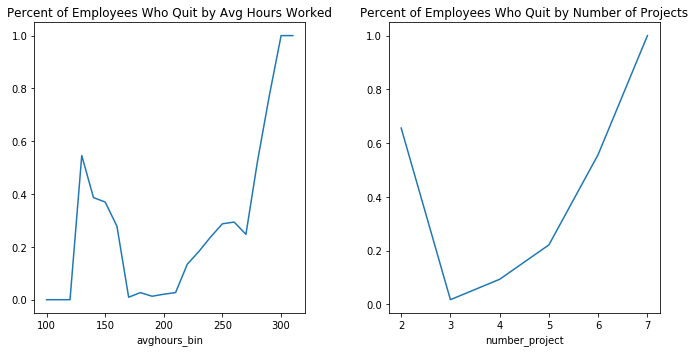

In [30]:
# Round hours worked to the nearest ten
def myround(x, base=10):
    return base * round(x/base)

# Add a column with hours worked rounded to the nearest ten, quickly check results
employee['avghours_bin'] = myround(employee['avg_hours'])
employee.head(10)

# Plot average hours worked and number of projects versus likelihood of leaving
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Percent of Employees Who Quit by Avg Hours Worked")
employee.groupby('avghours_bin').mean()['left'].plot()
plt.subplot(1,2,2)
plt.title("Percent of Employees Who Quit by Number of Projects")
employee.groupby('number_project').mean()['left'].plot()
plt.tight_layout()
plt.show()

Interestingly, there is an overall higher likelihood of quitting on the extreme low end of projects or work hours. These may be people that are part time, seasonal, or low wage roles that have high turnover. Or, these could be employees whose roles are being phased out or diminished, motivating them to leave. 

However, we're more interested in the people on the higher end of the workload continuum. Confirming what we saw with the averages, it appears that those who work high hours and are assigned an inordinately high number of projects demonstrate a much higher likelihood of quitting. This fits our general notion that a lot of employees who quit simply burn out after being overworked. There is an alternative explanation, though. It could be that many of these employees are simply "high performers," who naturally take on more work. If they quit at a higher rate, it may be because these employees are likelier to be sought out by other firms wishing to hire them.

Let's look at some of the other variables and their relationships to one another to illuminate whether the issue has to do with burnout or losing high performers.

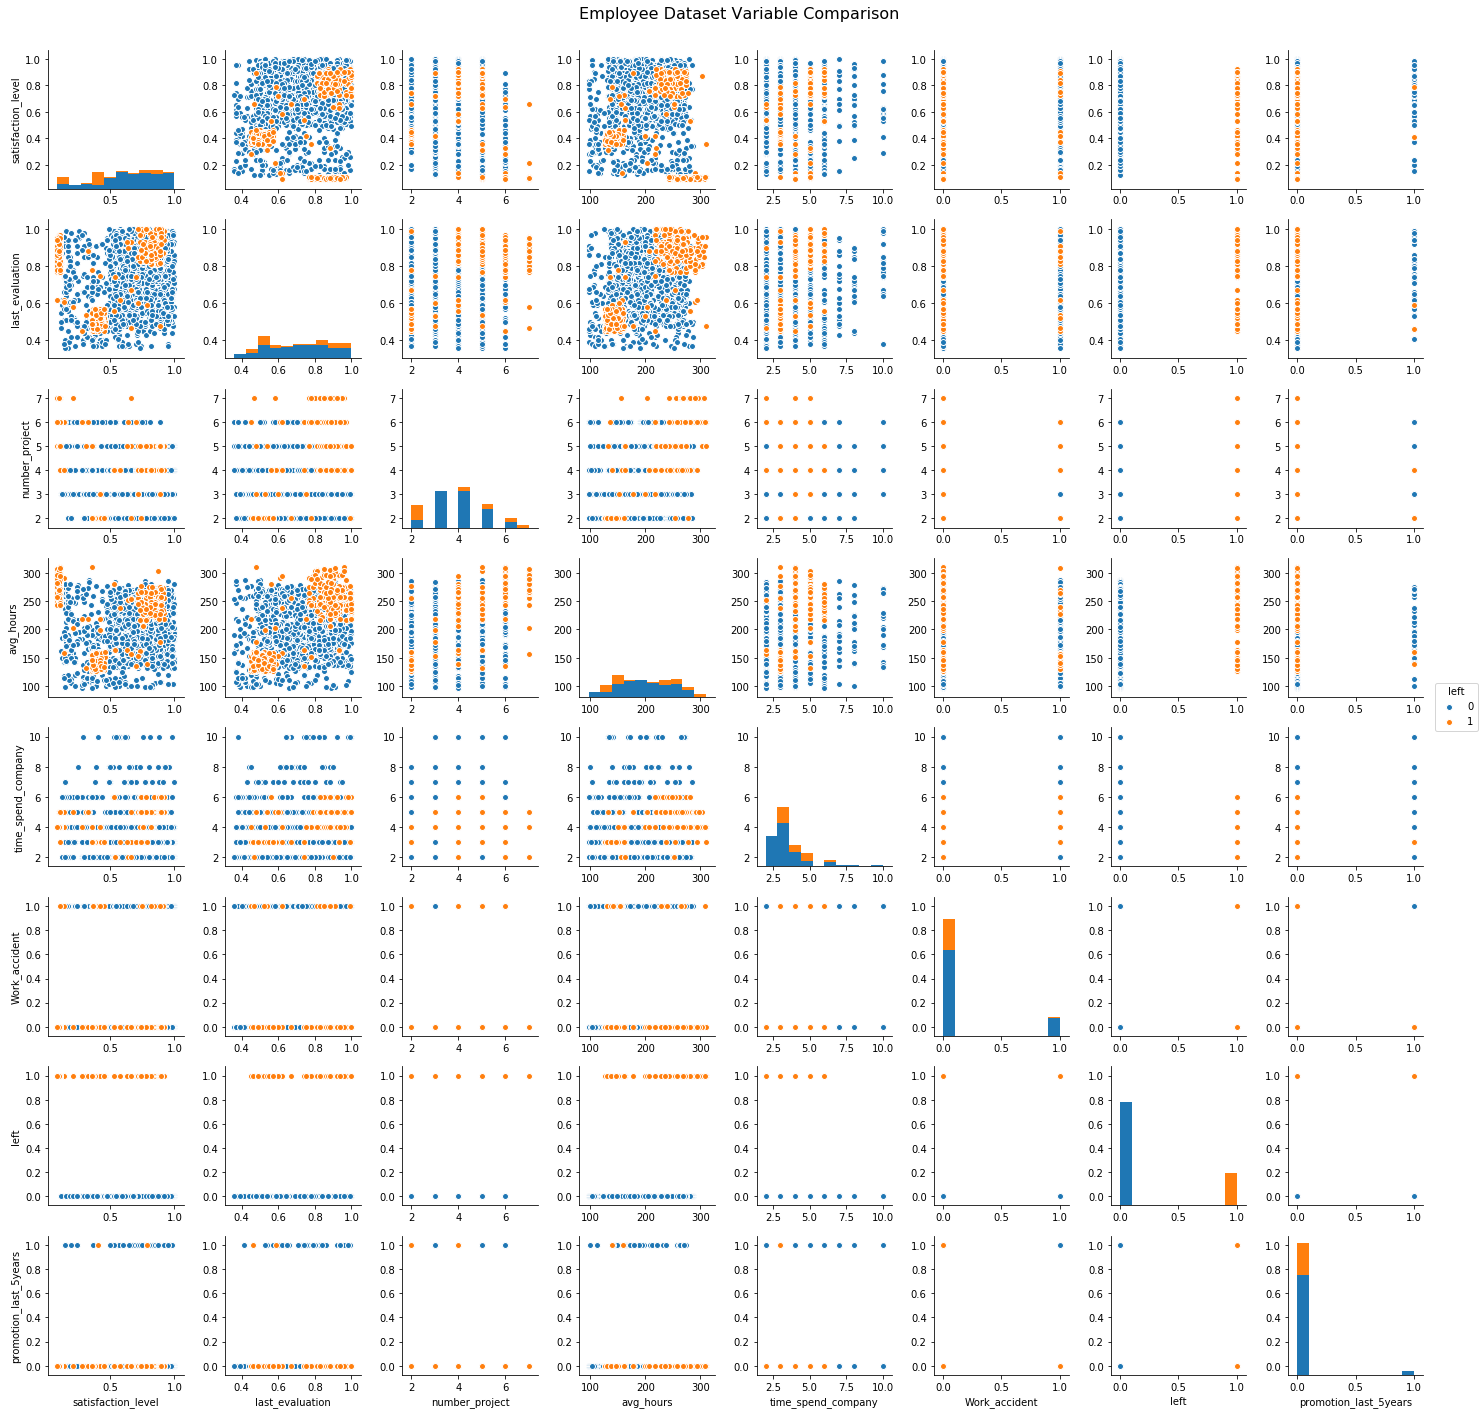

In [5]:
pairplot = sns.pairplot(employee.sample(frac=.1),hue='left')
plt.suptitle('Employee Dataset Variable Comparison',fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

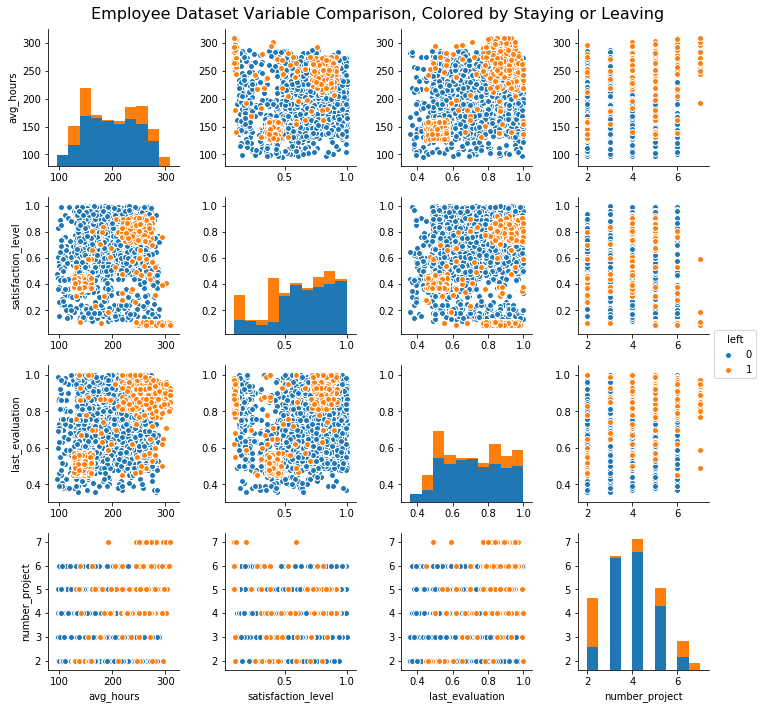

In [37]:
pairplot = sns.pairplot(employee.sample(frac=.15),vars=['avg_hours','satisfaction_level','last_evaluation','number_project'],hue='left')
plt.suptitle('Employee Dataset Variable Comparison, Colored by Staying or Leaving',fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

There's a few very interesting things about the above, particularly as relates to the average hours worked. We see that among employees that work many hours, some that quit were extremely unsatisfied with the job and may have burnt out, but a large portion actually were satisfied with their job and still left. Additionally, many of those who worked long hours and left were in fact highly rated employees. The same general trends can be seen for number of projects, another proxy for high performance.

There's certainly some evidence building that there may be more to the story than simply that employees that work a lot burn out and quit. There seems to be a group of people that work hard and take on lots of projects, but seem to enjoy their jobs. Let's zero in on these folks a little more.

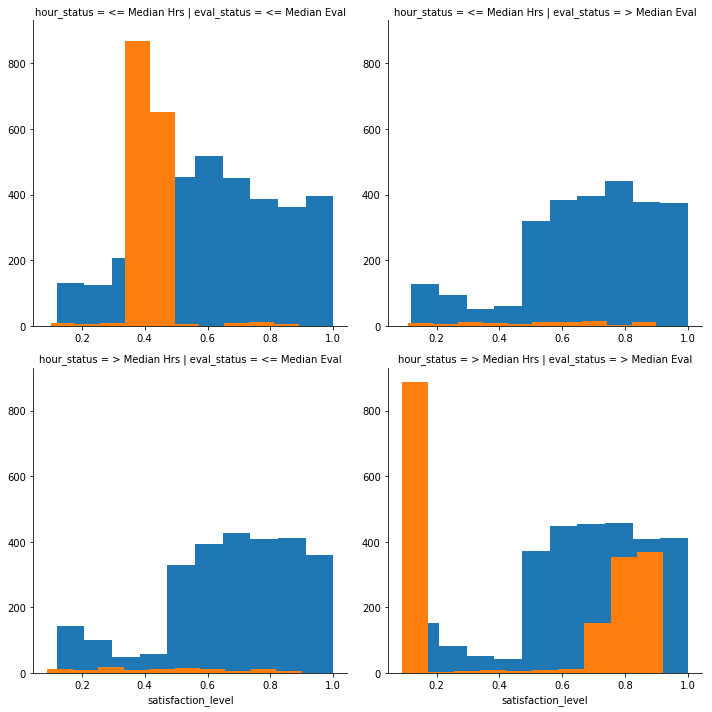

In [34]:
# Adding columns for whether employees are above or below the median for hours and evaluations
employee['hour_status'] = np.where(employee['avg_hours']>employee['avg_hours'].median(), '> Median Hrs', '<= Median Hrs')
employee['eval_status'] = np.where(employee['last_evaluation']>employee['last_evaluation'].median(), '> Median Eval', '<= Median Eval')

# Plotting a facet grid to compare how satisfaction compares among these groups, with whether the employee left layered in
facet = sns.FacetGrid(employee,row='hour_status',col='eval_status',hue='left',size=5)
facet = facet.map(plt.hist,"satisfaction_level")
plt.show()

The chart on the bottom right is most revealing. The peak on the right shows that among workers who work more hours than the average employee and are better reviewed than the average employee, there's a not insignificant portion of employees who also quite enjoy their job. If they're happy despite working those long hours and their managers agree they're doing a good job, I think it's likely that many of these people are simply high performers who are quitting not because of burnout, but because they're sought by other companies.

My research proposal will be based on this idea.

In [9]:
hour_splitter(150)

NameError: name 'hour_splitter' is not defined

In [ ]:
hours_med = employee['avg_hours'].median()
evaluation_med = employee['avg_hours'].median()

def hour_splitter(x):
    if x > hours_med:
        x = 'Above Average Hours'
    else: x = 'At or Below Avg Hours'

def evaluation_splitter(x):
    if x > hours_med:
        x = 'Above Average Hours'
    else: x = 'At or Below Avg Hours'

employee['hour_status'] = hour_splitter(employee['avg_hours'])
employee['eval_status'] = evaluation_splitter(employee['last_evaluation'])

facet = sns.FacetGrid(left,row='hour_status',col='eval_status',hue='left')
facet = facet.map(plt.hist,"satisfaction_level")

In [ ]:
left = employee[employee['left'] == 1]

In [ ]:
def satisfaction_bin(x):
    return np.floor(x*20)/20

employee['satisfaction_bin'] = satisfaction_bin(employee['satisfaction_level'])
print(employee['satisfaction_bin'])

In [ ]:
employee.groupby('satisfaction_bin').mean()['left'].plot()